In [ ]:
import pandas as pd

# Lesson 7 - Audio

## Lesson Video:

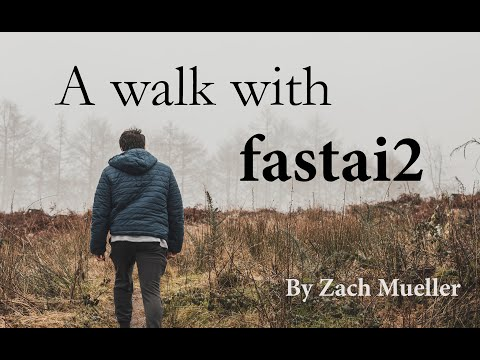

In [ ]:
#hide_input
from IPython.lib.display import YouTubeVideo
from datetime import timedelta 
start = int(timedelta(minutes=27, seconds=41).total_seconds())
YouTubeVideo('0IQYJNkAI3k', start=start)

In [32]:
#hide
#Run once per session
!pip install fastai fastcore==1.3.4 wwf fastaudio -q --upgrade

     |████████████████████████████████| 189 kB 5.3 MB/s 
     |████████████████████████████████| 186 kB 39.8 MB/s 
     |████████████████████████████████| 188 kB 43.9 MB/s 
     |████████████████████████████████| 188 kB 46.5 MB/s 
     |████████████████████████████████| 188 kB 41.6 MB/s 
     |████████████████████████████████| 187 kB 42.8 MB/s 
     |████████████████████████████████| 194 kB 41.4 MB/s 
     |████████████████████████████████| 193 kB 44.5 MB/s 
     |████████████████████████████████| 193 kB 45.7 MB/s 
     |████████████████████████████████| 193 kB 46.7 MB/s 
     |████████████████████████████████| 191 kB 44.9 MB/s 
     |████████████████████████████████| 191 kB 43.3 MB/s 
     |████████████████████████████████| 191 kB 26.4 MB/s 
     |████████████████████████████████| 191 kB 46.3 MB/s 
     |████████████████████████████████| 191 kB 40.2 MB/s 
     |████████████████████████████████| 191 kB 44.1 MB/s 
     |████████████████████████████████| 190 kB 40.4 MB/s 
     |█████████

In [24]:
#hide_input
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf', 'fastaudio', 'torchaudio'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, `wwf`, `fastaudio`, and `torchaudio` currently running at the time of writing this:
* `fastai` : 2.1.5 
* `fastcore` : 1.3.4 
* `wwf` : 0.0.16 
* `fastaudio` : 0.1.3 
* `torchaudio` : 0.9.0 
---

(Largely based on rbracco's tutorial, **big** thanks to him for his work on getting this going for us!)

`fastai`'s audio module has been in development for a while by active forum members:

* [rbracco](https://github.com/rbracco)
* [kevinbird15](https://github.com/kevinbird15)
* [mogwai](https://github.com/mogwai)
* [Hiromis](https://github.com/hiromis)
* [scart97](https://github.com/scart97)
* [hoftherose](https://github.com/hoftherose)
* [madhavajay](https://github.com/madhavajay)
* [Jo](https://github.com/aquietlife/)

## What makes Audio different?

While it is possible to train on raw audio (we simply pass in a 1D tensor of the signal), what is done now is to convert the audio to what is called a **spectrogram** to train on.

![](https://www.researchgate.net/profile/Phillip_Lobel/publication/267827408/figure/fig2/AS:295457826852866@1447454043380/Spectrograms-and-Oscillograms-This-is-an-oscillogram-and-spectrogram-of-the-boatwhistle.png)


## Free Digit Dataset

Essentially the audio version of `MNIST`, it contains 2,000 recordings from 10 speakers saying each digit 5 times. First, we'll grab the data and use a custom extract function:

In [34]:
import pkg_resources
def placeholder(x):
    raise pkg_resources.DistributionNotFound
pkg_resources.get_distribution = placeholder
import fastai
import fastaudio
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *

`tar_extract_at_filename` simply extracts at the file name (as the name suggests)

In [ ]:
path_dig = untar_data(URLs.SPEAKERS10, extract_func=tar_extract_at_filename)

Now we want to grab just the audio files.

In [35]:
audio_extensions[:5]

('.m3u', '.ram', '.au', '.snd', '.mp3')

In [ ]:
fnames = get_files(path_dig, extensions=audio_extensions)

In [ ]:
fnames[:5]

(#5) [Path('/root/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00268.wav'),Path('/root/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00111.wav'),Path('/root/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00309.wav'),Path('/root/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00255.wav'),Path('/root/.fastai/data/ST-AEDS-20180100_1-OS/f0002_us_f0002_00334.wav')]

We can convert any audio file to a tensor with `AudioTensor`. Let's try opening a file:

In [ ]:
at = AudioTensor.create(fnames[0])

In [ ]:
at, at.shape

(AudioTensor([[0.0000, 0.0000, 0.0000,  ..., 0.0002, 0.0002, 0.0003]]),
 torch.Size([1, 75520]))

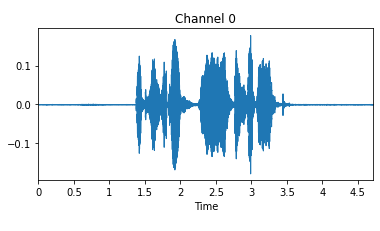

In [ ]:
at.show()

## Preparing the dataset

`fastai_audio` has a `AudioConfig` class which allows us to prepare different settings for our dataset. Currently it has:
* BasicMelSpectrogram
* BasicMFCC
* BasicSpectrogram
* Voice

We'll be using the **Voice** module today, as this dataset just contains human voices.

In [ ]:
cfg = AudioConfig.Voice()

Our configuration will limit options like the frequency range and the sampling rate

In [ ]:
cfg.f_max, cfg.sample_rate

(8000.0, 16000)

We can then make a transform from this configuration to turn raw audio into a workable spectrogram per our settings:

In [ ]:
aud2spec = AudioToSpec.from_cfg(cfg)

For our example, we'll crop out the original audio file to 1000 ms

In [ ]:
crop1s = ResizeSignal(1000)

Let's build a `Pipeline` how we'd expect our data to come in

In [ ]:
pipe = Pipeline([AudioTensor.create, crop1s, aud2spec])

And try visualizing what our newly made data becomes.

First, we'll remove that cropping:

In [ ]:
pipe = Pipeline([AudioTensor.create, aud2spec])

/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


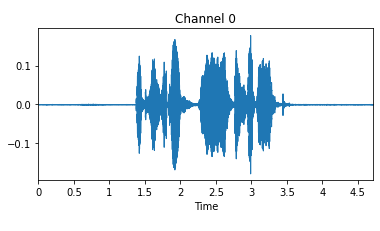

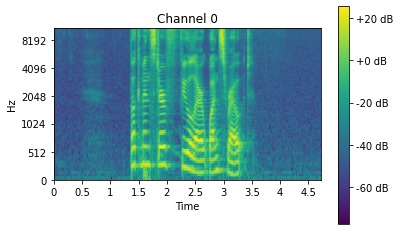

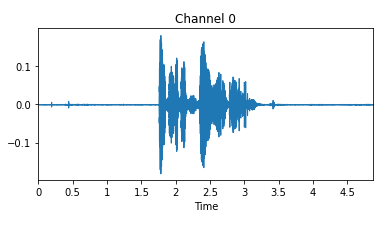

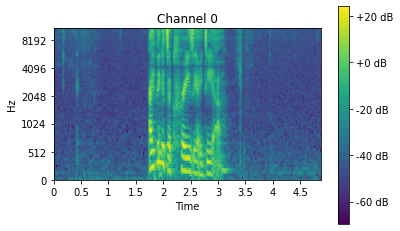

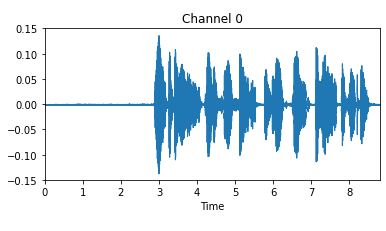

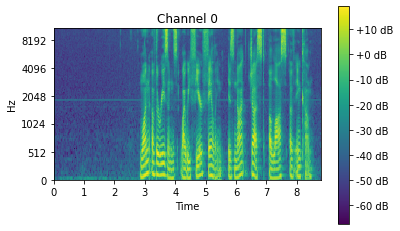

In [ ]:
for fn in fnames[:3]:
  audio = AudioTensor.create(fn)
  audio.show()
  pipe(fn).show()

You can see that they're not all the same size here. Let's add that cropping back in:

In [ ]:
pipe = Pipeline([AudioTensor.create, crop1s, aud2spec])

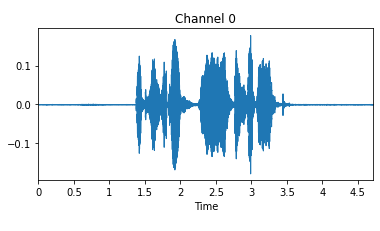

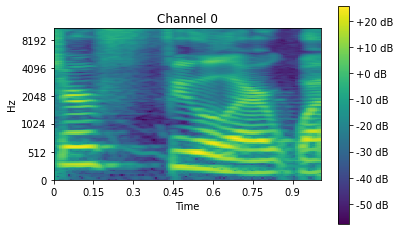

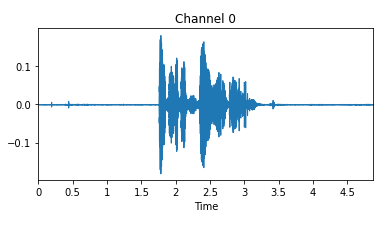

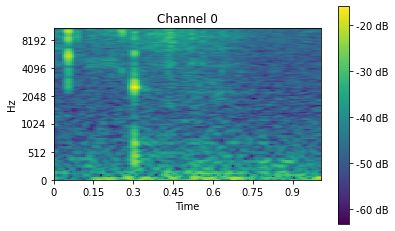

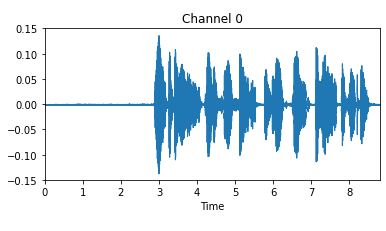

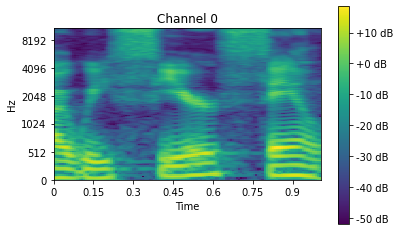

In [ ]:
for fn in fnames[:3]:
  audio = AudioTensor.create(fn)
  audio.show()
  pipe(fn).show()

And now everythign is 128x63

## Using the `DataBlock` API:

* We'll want to use our same transforms we used for the `Pipeline`
* An appropriate `getter`
* An appropriate labeller

For our transforms, we'll want the same ones we used before

In [ ]:
item_tfms = [ResizeSignal(1000), aud2spec]

Our filenames are labelled by the number followed by the name of the individual:
* `4_theo_37.wav`
* `2_nicolas_7.wav`

In [ ]:
get_y = lambda x: x.name[0]

In [ ]:
aud_digit = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms = item_tfms,
                 get_y=get_y)

And now we can build our `DataLoaders`

In [ ]:
dls = aud_digit.dataloaders(path_dig, bs=64)

Let's look at a batch

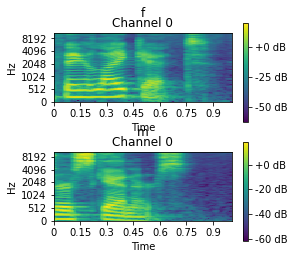

In [ ]:
dls.show_batch(max_n=3)

## Training

Now that we have our `Dataloaders`, we need to make a model. We'll make a function that changes a `Learner`'s first layer to accept a 1 channel input (similar to how we did for the Bengali.AI model)

In [ ]:
def alter_learner(learn, n_channels=1):
  "Adjust a `Learner`'s model to accept `1` channel"
  layer = learn.model[0][0]
  layer.in_channels=n_channels
  layer.weight = nn.Parameter(layer.weight[:,1,:,:].unsqueeze(1))
  learn.model[0][0] = layer

In [ ]:
learn = Learner(dls, xresnet18(), CrossEntropyLossFlat(), metrics=accuracy)

Now we need to grab our number of channels:

In [ ]:
n_c = dls.one_batch()[0].shape[1]; n_c

1

In [ ]:
alter_learner(learn, n_c)

Now we can find our learning rate and fit!

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.0030199517495930195)

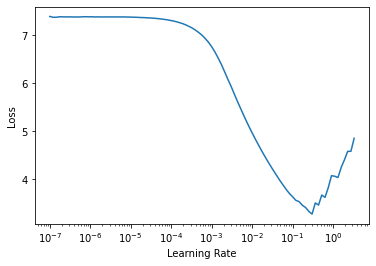

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

In [ ]:
learn.fit_one_cycle(5, 1e-3)

Not bad for zero data augmentation! But let's see if augmentation can help us out here!

## Data Augmentation

We can use the `SpectrogramTransformer` class to prepare some transforms for us

In [ ]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)

Let's take a look at our original settings:

In [ ]:
aud2spec.settings

{'mel': 'True',
 'to_db': 'False',
 'sample_rate': 16000,
 'n_fft': 1024,
 'win_length': 1024,
 'hop_length': 128,
 'f_min': 50.0,
 'f_max': 8000.0,
 'pad': 0,
 'n_mels': 128,
 'window_fn': <function _VariableFunctionsClass.hann_window>,
 'power': 2.0,
 'normalized': False,
 'wkwargs': None,
 'stype': 'power',
 'top_db': None,
 'sr': 16000,
 'nchannels': 1}

And we'll narrow this down a bit

In [ ]:
aud2spec = DBMelSpec(n_mels=128, f_max=10000, n_fft=1024, hop_length=128, top_db=100)

For our transforms, we'll use:
* `RemoveSilence`
  * Splits a signal at points of silence more than 2 * `pad_ms` (default is 20)
* `CropSignal`
  * Crops a signal by `duration` and adds padding if needed
* `aud2spec`
  * Our `SpectrogramTransformer` with parameters
* `MaskTime`
  * Wrapper for `MaskFre`, which applies `einsum` operations
* `MaskFreq`
  * [SpecAugment Time Masking](https://arxiv.org/abs/1904.08779)

Let's look a bit more at the padding `CropSignal` uses:

There are three different types:
* `AudioPadTypes.Zeros`: The default, random zeros before and after
* `AudioPadType.Repeat`: Repeat the signal until proper length (great for coustic scene classification and voice recognition, terrible for speech recognition)
* `AudioPadtype.ZerosAfter`: This is the default for many other libraries, just pad with zeros until you get the specified length.

Now let's rebuild our `DataBlock`:

In [ ]:
item_tfms = [RemoveSilence(), ResizeSignal(1000), aud2spec, MaskTime(size=4), MaskFreq(size=10)]

In [ ]:
aud_digit = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms = item_tfms,
                 get_y=get_y)

In [ ]:
dls = aud_digit.dataloaders(path_dig, bs=128)

Let's look at some augmented data:

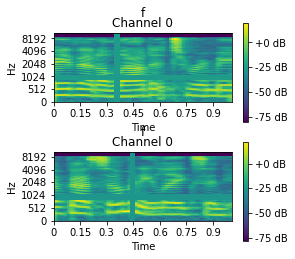

In [ ]:
dls.show_batch(max_n=3)

Let's try training again. Also, since we have to keep making an adustment to our model, let's make an `audio_learner` function similar to `cnn_learner`:

In [ ]:
def audio_learner(dls, arch, loss_func, metrics):
  "Prepares a `Learner` for audio processing"
  learn = Learner(dls, arch, loss_func, metrics=metrics)
  n_c = dls.one_batch()[0].shape[1]
  if n_c == 1: alter_learner(learn)
  return learn

In [ ]:
learn = audio_learner(dls, xresnet18(), CrossEntropyLossFlat(), accuracy)

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.002511886414140463)

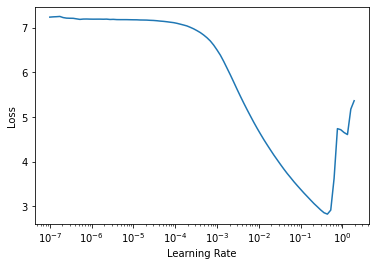

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 3e-3)

In [ ]:
learn.fit_one_cycle(10, 3e-4)

With the help of some of our data augmentation, we were able to perform a bit higher!

## Mel Frequency Cepstral Coefficient (MFCC)

Now let's look at that MFCC option we said earlier. MFCC's are a "linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency" - Wikipedia. But what does that mean?

![](https://www.researchgate.net/publication/335398843/figure/fig1/AS:796124961058818@1566822390492/MFCC-mel-frequency-cepstral-coefficients-characteristic-vectors-extraction-flow.png)

Let's try it out!

In [ ]:
aud2mfcc = AudioToMFCC(n_mfcc=40, melkwargs={'n_fft':2048, 'hop_length':256,
                                             'n_mels':128})

In [ ]:
item_tfms = [ResizeSignal(1000), aud2mfcc]

There's a shortcut for replacing the item transforms in a `DataBlock`:

In [ ]:
aud_digit.item_tfms

(#8) [ToTensor:
encodes: (PILMask,object) -> encodes
(PILBase,object) -> encodes
decodes: ,Resample:
encodes: (AudioTensor,object) -> encodes
decodes: ,DownmixMono:
encodes: (AudioTensor,object) -> encodes
decodes: ,RemoveSilence:
encodes: (AudioTensor,object) -> encodes
decodes: ,ResizeSignal:
encodes: (AudioTensor,object) -> encodes
decodes: ,AudioToSpec:
encodes: (AudioTensor,object) -> encodes
decodes: ,MaskTime:
encodes: (AudioSpectrogram,object) -> encodes
decodes: ,MaskFreq:
encodes: (AudioSpectrogram,object) -> encodes
decodes: ]

In [ ]:
aud_digit.item_tfms = item_tfms

In [ ]:
dls = aud_digit.dataloaders(path_dig, bs=128)

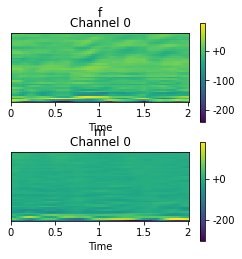

In [ ]:
dls.show_batch(max_n=3)

Now let's build our learner and train again!

In [ ]:
learn = audio_learner(dls, xresnet18(), CrossEntropyLossFlat(), accuracy)

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.0020892962347716093)

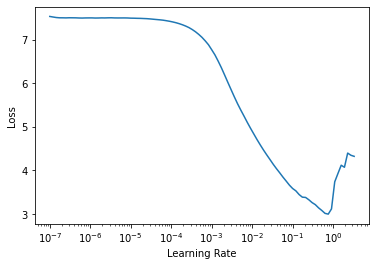

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

Now we can begin to see why choosing your augmentation is important!

## MFCC + Delta:

The last transform we'll discuss is the `Delta` transform:

> Local estimate of the derivative of the input data along the selected axis.

This allows multiple-channeled inputs from one signal

In [ ]:
item_tfms = [ResizeSignal(1000), aud2mfcc, Delta()]

In [ ]:
aud_digit.item_tfms = item_tfms

In [ ]:
dls = aud_digit.dataloaders(path_dig, bs=128)

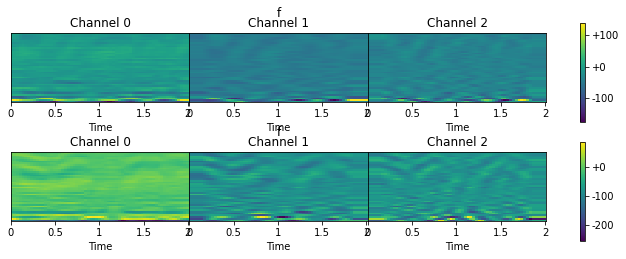

In [ ]:
dls.show_batch(max_n=3)

Let's try training one more time:

In [ ]:
learn = audio_learner(dls, xresnet18(), CrossEntropyLossFlat(), accuracy)

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.0014454397605732083)

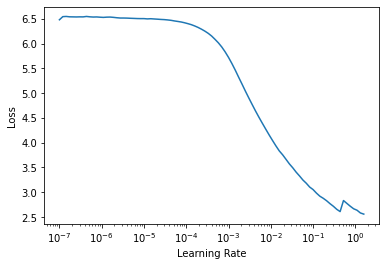

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

Let's try fitting for a few more:

In [ ]:
learn.fit_one_cycle(5, 1e-2/10)

In [3]:
import pandas as pd

In [4]:
data = pd.read_csv("comma labels.csv", index_col='path')

In [5]:
data

pattern        kana  syl  drop
path                                                              
ある.yomi000142BB_0596.mp3                 頭高          アル    2     1
ある.yomi000142BB_0596.mp3                 頭高          アル    2     1
思う.yomi0006C617_043A.mp3                 中高         オモウ    3     2
など.yomi000240B7_0028.mp3                 頭高          ナド    2     1
私.yomi00092F63_0072.mp3                  平板        ワタくシ    4     0
...                                     ...         ...  ...   ...
くも膜下出血_蜘蛛膜下出血.yomi0001AAD1_0622.mp3      中高  クモマッカしュッケツ   10     6
捜す.yomi00072507_0088.mp3                 平板        サカ゚ス    4     0
捜し物.yomi000724FD_0424.mp3                平板      サカ゚シモノ    6     0
あこや貝_阿古屋貝.yomi00013767_0114.mp3          中高      アコヤカ゚イ    6     3
あこや貝_阿古屋貝.yomi00013767_0114.mp3          中高      アコヤカ゚イ    6     3

[74191 rows x 4 columns]

In [10]:
data.loc['１すくい_一掬い.yomi000120BB_01C8.mp3']

pattern   kana  syl  drop
path                                                    
１すくい_一掬い.yomi000120BB_01C8.mp3      中高  ひトすクイ    5     2
１すくい_一掬い.yomi000120BB_01C8.mp3      中高  ひトすクイ    5     2

In [11]:
data.loc['出し抜く.yomi0004BDF8_06F2.mp3']

pattern      平板
kana       ダシヌク
syl           4
drop          0
Name: 出し抜く.yomi0004BDF8_06F2.mp3, dtype: object

In [9]:
data.loc['ある.yomi000142BB_0596.mp3']

pattern kana  syl  drop
path                                            
ある.yomi000142BB_0596.mp3      頭高   アル    2     1
ある.yomi000142BB_0596.mp3      頭高   アル    2     1

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
path = Path('/content/drive/MyDrive')

In [38]:
path = path / '1000sample'

In [39]:
at = AudioTensor.create(path.ls()[0])

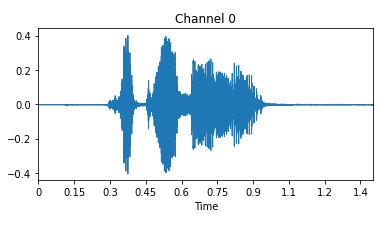

In [41]:
at.show()

In [42]:
cfg = AudioConfig.Voice()

In [43]:
aud2spec = AudioToSpec.from_cfg(cfg)

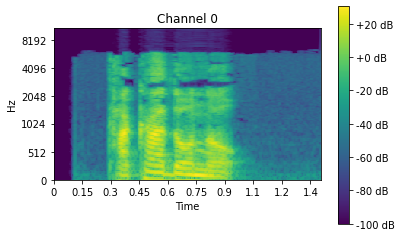

In [45]:
aud2spec(at).show()

In [46]:
crop2s = ResizeSignal(2000)

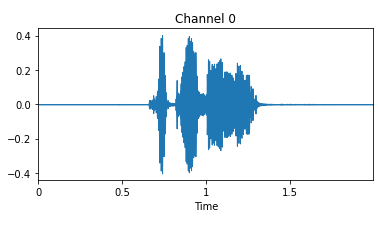

In [47]:
crop2s(at).show()

In [48]:
pipe = Pipeline([AudioTensor.create, crop2s, aud2spec])

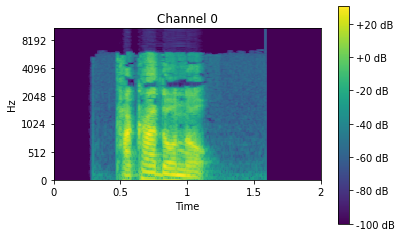

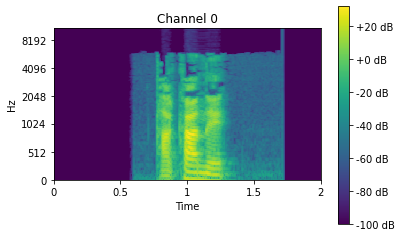

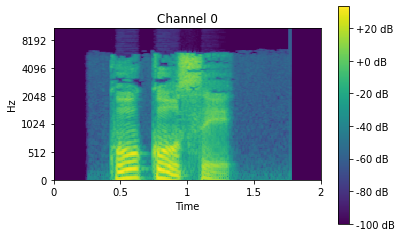

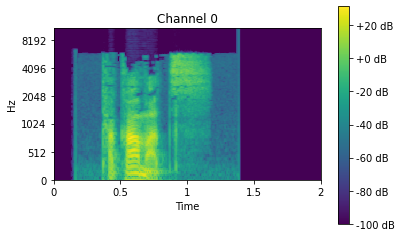

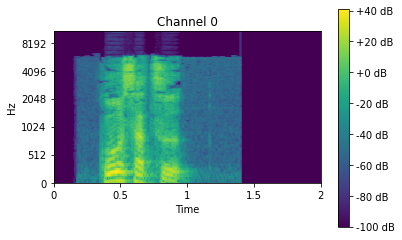

In [51]:
for i in range(5):
  pipe(path.ls()[i]).show()

In [52]:
#get_y=using_attr(data[data.path == name]['pattern'].values[0]), 'name')

In [59]:
data.loc['ある.yomi000142BB_0596.mp3']['pattern']

'頭高'

In [92]:
data.reset_index()[data.reset_index().duplicated(keep=False)].to_csv('duplicates.csv')

In [96]:
data[data.index.duplicated(keep=False)].to_csv('path_dup.csv')

In [84]:
data.duplicated().sum()

15695

In [88]:
data.reset_index()

path pattern        kana  syl  drop
0                 ある.yomi000142BB_0596.mp3      頭高          アル    2     1
1                 ある.yomi000142BB_0596.mp3      頭高          アル    2     1
2                 思う.yomi0006C617_043A.mp3      中高         オモウ    3     2
3                 など.yomi000240B7_0028.mp3      頭高          ナド    2     1
4                  私.yomi00092F63_0072.mp3      平板        ワタくシ    4     0
...                                    ...     ...         ...  ...   ...
74186  くも膜下出血_蜘蛛膜下出血.yomi0001AAD1_0622.mp3      中高  クモマッカしュッケツ   10     6
74187             捜す.yomi00072507_0088.mp3      平板        サカ゚ス    4     0
74188            捜し物.yomi000724FD_0424.mp3      平板      サカ゚シモノ    6     0
74189      あこや貝_阿古屋貝.yomi00013767_0114.mp3      中高      アコヤカ゚イ    6     3
74190      あこや貝_阿古屋貝.yomi00013767_0114.mp3      中高      アコヤカ゚イ    6     3

[74191 rows x 5 columns]

In [97]:
data = data.reset_index()

removing complete duplicates

In [105]:
data = data[-data.duplicated()]

In [106]:
data.to_csv('labels complete duplicates removed.csv')

duplicate labels

In [110]:
data.duplicated(subset=['path'], keep=False).sum()

687

In [113]:
data = data[-data.duplicated(subset=['path'], keep=False)]

In [114]:
data.to_csv('labels_no_duplicates.csv')

In [124]:
sr = data[data.path == '捜す.yomi00072507_0088.mp3']['pattern'].values[0]

In [129]:
sr.values[0]

'平板'

In [ ]:
item_tfms = [ResizeSignal(1000), aud2spec]

In [132]:
def get_label(fn):
  return data[data.path == fn]['pattern'].values[0]

In [133]:
audpitch = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms = [crop2s, aud2spec],
                 get_y=using_attr(get_label, 'name'))

In [135]:
dls = audpitch.dataloaders(path, bs=64)

IndexError: ignored

In [150]:
for fn in path.ls():
  print(fn)
  try:
    get_label(fn.name)
  except: fn.unlink()

/content/drive/MyDrive/1000sample/高殿.yomi000B94CD_06B4.mp3
平板
/content/drive/MyDrive/1000sample/高根.yomi000B947A_02D2.mp3
平板
/content/drive/MyDrive/1000sample/高校生.yomi000B9470_0746.mp3
中高
/content/drive/MyDrive/1000sample/高松.yomi000B9450_026E.mp3
中高
/content/drive/MyDrive/1000sample/高札.yomi000B9448_02B2.mp3
平板
/content/drive/MyDrive/1000sample/高校.yomi000B9468_027A.mp3
平板
/content/drive/MyDrive/1000sample/高木.yomi000B9440_03CE.mp3
平板
/content/drive/MyDrive/1000sample/高望み.yomi000B9436_0692.mp3
/content/drive/MyDrive/1000sample/高揚.yomi000B9413_021A.mp3
平板
/content/drive/MyDrive/1000sample/高曇り.yomi000B9424_012A.mp3
平板
/content/drive/MyDrive/1000sample/高文.yomi000B941C_016E.mp3
平板
/content/drive/MyDrive/1000sample/高望み.yomi000B942D_0306.mp3
中高
/content/drive/MyDrive/1000sample/高架線.yomi000B945F_05AE.mp3
平板
/content/drive/MyDrive/1000sample/高架.yomi000B9458_03DA.mp3
頭高
/content/drive/MyDrive/1000sample/高所.yomi000B940A_07D6.mp3
頭高
/content/drive/MyDrive/1000sample/高慢ちき.yomi000B9406_01A4.mp3
/conten

In [151]:
for fn in path.ls():
  print(fn)
  print(get_label(fn.name))

/content/drive/MyDrive/1000sample/高殿.yomi000B94CD_06B4.mp3
平板
/content/drive/MyDrive/1000sample/高根.yomi000B947A_02D2.mp3
平板
/content/drive/MyDrive/1000sample/高校生.yomi000B9470_0746.mp3
中高
/content/drive/MyDrive/1000sample/高松.yomi000B9450_026E.mp3
中高
/content/drive/MyDrive/1000sample/高札.yomi000B9448_02B2.mp3
平板
/content/drive/MyDrive/1000sample/高校.yomi000B9468_027A.mp3
平板
/content/drive/MyDrive/1000sample/高木.yomi000B9440_03CE.mp3
平板
/content/drive/MyDrive/1000sample/高揚.yomi000B9413_021A.mp3
平板
/content/drive/MyDrive/1000sample/高曇り.yomi000B9424_012A.mp3
平板
/content/drive/MyDrive/1000sample/高文.yomi000B941C_016E.mp3
平板
/content/drive/MyDrive/1000sample/高望み.yomi000B942D_0306.mp3
中高
/content/drive/MyDrive/1000sample/高架線.yomi000B945F_05AE.mp3
平板
/content/drive/MyDrive/1000sample/高架.yomi000B9458_03DA.mp3
頭高
/content/drive/MyDrive/1000sample/高所.yomi000B940A_07D6.mp3
頭高
/content/drive/MyDrive/1000sample/馬てい_馬蹄.yomi000B8921_00D8.mp3
平板
/content/drive/MyDrive/1000sample/香道.yomi000B88F0_03B0.mp3
平板


In [152]:
dls = audpitch.dataloaders(path, bs=64)

AttributeError: ignored

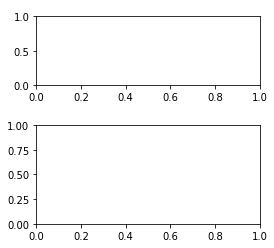

In [155]:
dls.show_batch(max_n=5)

In [156]:
learn = Learner(dls, xresnet18(), CrossEntropyLossFlat(), metrics=accuracy)

In [157]:
learn.lr_find()

RuntimeError: ignored

In [159]:
learn.fit_one_cycle(1)

RuntimeError: ignored

In [160]:
n_c = dls.one_batch()[0].shape[1]; n_c

1

In [161]:
def alter_learner(learn, n_channels=1):
  "Adjust a `Learner`'s model to accept `1` channel"
  layer = learn.model[0][0]
  layer.in_channels=n_channels
  layer.weight = nn.Parameter(layer.weight[:,1,:,:].unsqueeze(1))
  learn.model[0][0] = layer

In [162]:
alter_learner(learn, n_c)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.00363078061491251)

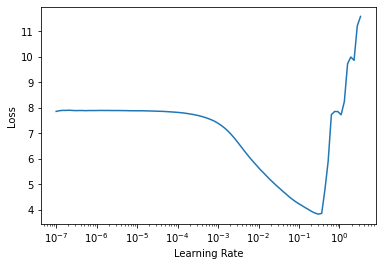

In [163]:
learn.lr_find()

In [165]:
learn.fit_one_cycle(5, 1e-3)

In [166]:
learn.fit_one_cycle(5, 1e-4)

In [171]:
train = dls.train

In [173]:
train.sorted

(#2) [<bound method L.sorted of TfmdLists: [Path('/content/drive/MyDrive/1000sample/高積雲.yomi000B9552_02BA.mp3'), Path('/content/drive/MyDrive/1000sample/鬼才.yomi000B990C_00AC.mp3'), Path('/content/drive/MyDrive/1000sample/馬具.yomi000B89B2_07CC.mp3'), Path('/content/drive/MyDrive/1000sample/鬼神.yomi000B9951_07F0.mp3'), Path('/content/drive/MyDrive/1000sample/高圧.yomi000B928A_04F8.mp3'), Path('/content/drive/MyDrive/1000sample/黙考.yomi000BA7E7_0518.mp3'), Path('/content/drive/MyDrive/1000sample/魔女.yomi000B9A51_024C.mp3'), Path('/content/drive/MyDrive/1000sample/鼻っ面.yomi000BA8E9_0306.mp3'), Path('/content/drive/MyDrive/1000sample/高潔.yomi000B94F9_0210.mp3'), Path('/content/drive/MyDrive/1000sample/高射砲.yomi000B932B_068E.mp3'), Path('/content/drive/MyDrive/1000sample/騒々しい.yomi000B8D9A_05F4.mp3'), Path('/content/drive/MyDrive/1000sample/黙々.yomi000BA741_058A.mp3'), Path('/content/drive/MyDrive/1000sample/駆虫剤.yomi000B8CAE_07C0.mp3'), Path('/content/drive/MyDrive/1000sample/黒板塀.yomi000BA5C9_0170.mp3'

In [177]:
m = learn.model

In [186]:
y = dls[0]

In [192]:
names = [fn.name for fn in path.ls()]

In [208]:
datasample =  data[data.path.isin(names)]

In [211]:
datasample.groupby('pattern').count()

path  kana  syl  drop
pattern                       
中高        229   229  229   229
尾高         18    18   18    18
平板        403   403  403   403
頭高         78    78   78    78

In [212]:
data.groupby('pattern').count()

path   kana    syl   drop
pattern                            
中高       24444  24444  24444  24444
尾高        1461   1461   1461   1461
平板       30551  30551  30551  30551
頭高       10038  10038  10038  10038